# <center>code for Named entity recognition for Fintech — NER in financial news

<center>Yixi Zhou, Jingyi Zeng, Qianru Li</center>

<font color="grey">The code part is done by Yixi Zhou.</font>

In [77]:
from os.path import join
from codecs import open
import matplotlib.pyplot as plt

## <center>Part1: Data Collection and Annotation </center>

In [78]:
# Read the data file
with open('./NER_data/origin.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
valid_labels = ['B-LOC', 'B-ORG', 'B-PER', 'E-GPE', 'E-LOC', 'E-ORG', 'E-PER',
                    'M-GPE', 'M-LOC', 'M-ORG', 'M-PER', 'O', 'S-GPE', 'B-GPE']
# Process each line
output = []
count = 1
line_count = 1
for line in lines:
    # Skip empty lines
    if line.strip() == '':
        # print(f"\033[91mline{line_count}\033[0m")
        line_count += 1
        output.append('')
        continue

    # Split each line by spaces
    parts = line.strip().split()
    count += 1
    # If a line has multiple words, keep only the first word
    if len(parts) > 1:
        if parts[len(parts)-1] not in valid_labels:
            print(f"Error: Invalid label '{parts[1]}' in line: {line.strip()}, in {count}")
            continue
        output.append(parts[0][0] + ' ' + parts[len(parts)-1])
    # If a line has only one word, add it directly to the output
    else:
        print(f"Error: Invalid '{parts[0]}' in line: {line.strip()}, in {count}")

# Write the processed data to a new file
with open('./NER_data/outputli.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(output))
with open('./NER_data/outputzeng.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(output))

print("Data processing completed.")

Data processing completed.


In [79]:
# reading data
def build_corpus(split, data_dir="./NER_data"):
    assert split in ['train', 'test']
    word_lists = []
    tag_lists = []
    with open(join(data_dir, split+".char.bmes"), 'r', encoding='utf-8') as f:
        word_list = []
        tag_list = []
        # count = 1
        for line in f:
            if line != '\r\n':
                word, tag = line.strip('\n').split()
                word_list.append(word)
                tag_list.append(tag)
                # print(count)
                # count += 1
            else:
                word_lists.append(word_list)
                tag_lists.append(tag_list)
                word_list = []
                tag_list = []
                # print(count)
                # count += 1
    if split == 'train':
        word2id = build_map(word_lists)
        tag2id = build_map(tag_lists)
        return word_lists, tag_lists, word2id, tag2id
    else:
        return word_lists, tag_lists

def build_map(lists):
    maps = {}
    for list_ in lists:
        for element in list_:
            if element not in maps:
                maps[element] = len(maps)
    return maps

In [80]:
# Read the data
print("Reading the data...")
train_word_lists, train_tag_lists, word2id, tag2id = build_corpus("train")
test_word_lists, test_tag_lists = build_corpus("test")
print("Data reading successful")

Reading the data...
Data reading successful


## <center> Part2: HMM Named Entity Recognition</center>


In [81]:
import torch
import sys

class HMM(object):
    def __init__(self, N, M):
        """Args:
            N: The number of states, which corresponds to the number of different tags/labels.
            M: The number of observations, which corresponds to the number of different words.
        """
        self.N = N
        self.M = M
    
        # Transition probability matrix. A[i][j] represents the probability of transitioning from state i to state j.
        self.A = torch.zeros(N, N)
        # Emission probability matrix. B[i][j] represents the probability of observing the j-th observation when in the i-th state.
        self.A_weighted = torch.zeros(N, N)  # weighted

        self.B = torch.zeros(N, M)
        # Initial state probability. Pi[i] represents the probability of being in the i-th state at the initial time step.
        self.Pi = torch.zeros(N)
    
    def train(self, word_lists, tag_lists, word2id, tag2id, entity_weight_tag = {'B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-PER', 'E-PER', 'M-PER', 'S-PER'}, setweighted = 2.5):
        """
        Train the Hidden Markov Model parameters.
        Args:
            word_lists (list): A list of word sequences.
            tag_lists (list): A list of tag/label sequences corresponding to the word sequences.
            word2id (dict): A dictionary mapping words to their unique IDs.
            tag2id (dict): A dictionary mapping tags/labels to their unique IDs.
        """

        # Estimate the transition probability matrix
        for tag_list in tag_lists:
            seq_len = len(tag_list)
            for i in range(seq_len - 1):
                current_tagid = tag2id[tag_list[i]]
                next_tagid = tag2id[tag_list[i+1]]
                self.A[current_tagid][next_tagid] += 1
                self.A_weighted[current_tagid][next_tagid] += 1

        # Problem: If an element has never appeared, its value will be 0, which is not allowed in subsequent calculations.
        # Solution: We add a very small number to the probabilities that are equal to 0.
        self.A[self.A == 0.] = 1e-10
        self.A_weighted[self.A_weighted == 0.] = 1e-10
        self.A = self.A / self.A.sum(dim=1, keepdim=True)  # Normalize each row to get the probabilities.
        self.A_weighted = self.A_weighted / self.A_weighted.sum(dim=1, keepdim=True)  
        
         # 定义需要增加权重的实体标签
        self.entity_tags = entity_weight_tag
        entity_tag_ids = [tag2id[tag] for tag in self.entity_tags]

        # 增加少数命名实体类别的权重
        self.entity_weight = setweighted
        self.A_weighted[:, entity_tag_ids] *= self.entity_weight
        self.A_weighted = self.A_weighted / self.A_weighted.sum(dim=1, keepdim=True)
        
        # Use imshow() to plot a heatmap of the transition matrix
        tensor_data = self.A
        plt.figure(figsize=(12, 12))
        plt.imshow(tensor_data, cmap='viridis')
        plt.colorbar()
        plt.title('Transition Matrix Visualization')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.savefig("./pic/transition.png", dpi=600)

       
        # plt.show()   
        plt.close()
        tensor_data = self.A_weighted
        plt.figure(figsize=(12, 12))
        plt.imshow(tensor_data, cmap='viridis')
        plt.colorbar()
        plt.title('Transition Matrix Visualization')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.savefig("./pic/weighted-transition.png", dpi=600)
         # Add value labels to each cell
        for i in range(17):
            for j in range(17):
                plt.text(j, i, f"{tensor_data[i, j]:.2f}", ha='center', va='center', color='w')
        # Display the plot
        plt.show()   

        # Estimate the emission probability matrix
        for tag_list, word_list in zip(tag_lists, word_lists):
            assert len(tag_list) == len(word_list)
            for tag, word in zip(tag_list, word_list):
                tag_id = tag2id[tag]
                word_id = word2id[word]
                self.B[tag_id][word_id] += 1
        self.B[self.B == 0.] = 1e-10
        self.B = self.B / self.B.sum(dim=1, keepdim=True)
    
        # count1 = 0
        # Estimate the initial state probability
        for tag_list in tag_lists:
            # count1 += 1
            init_tagid = tag2id[tag_list[0]]
            self.Pi[init_tagid] += 1
        self.Pi[self.Pi == 0.] = 1e-10
        self.Pi = self.Pi / self.Pi.sum()
    
        
    def test(self, word_lists, word2id, tag2id, weight=0):
        pred_tag_lists = []
        print("Progress:")
        step = 0
        for word_list in word_lists:
            step+=1
            progress = (step + 1) / len(word_lists) * 100
            print(f"\r[{'=' * int(progress // 2)}{'-' * (50 - int(progress // 2))}] {progress:.2f}%", end="")
            sys.stdout.flush()
            pred_tag_list = self.decoding(word_list, word2id, tag2id, weight)
            pred_tag_lists.append(pred_tag_list)
        print("\r[{'=' * 50}] 100.00%")
        return pred_tag_lists

    def decoding(self, word_list, word2id, tag2id, weight=0):
        # Problem: When the entire chain is very long, the multiplication of many small probabilities can lead to underflow.
        # Solution: Use logarithmic probability, which maps very small probabilities in the original space to large negative numbers in the logarithmic space.
        # At the same time, the multiplication operation becomes a simple addition operation.
        if weight:
            self.A = self.A_weighted
        A = torch.log(self.A)
        B = torch.log(self.B)
        Pi = torch.log(self.Pi)
        
        # Initialize the Viterbi matrix, which has dimensions [number of states, sequence length]
        # where viterbi[i, j] represents the maximum probability of the sequence of labels up to the jth label, where the jth label is i.
        seq_len = len(word_list)
        viterbi = torch.zeros(self.N, seq_len)
        
        # The backpointer matrix has the same size as the Viterbi matrix
        # backpointer[i, j] stores the id of the label at position j-1, when the label at position j is i
        # During decoding, we use the backpointer to backtrack and find the optimal path
        
        backpointer = torch.zeros(self.N, seq_len).long()  
        # The .long() converts the backpointer matrix elements to long integers (64-bit signed integers)

        # self.Pi[i] represents the probability that the first word is labeled as i
        # Bt[word_id] represents the probability of the various labels when the word is word_id
        # self.A.t()[tag_id] represents the probability of transitioning to the label with id tag_id from any other label
        
        # So the first step is:
        start_wordid = word2id.get(word_list[0], None)
        # First, try to find the value corresponding to the key word_list[0] in the word2id dictionary.
        # If found, return the corresponding value.
        # If not found, return the default value None.
        Bt = B.t()  # Transpose the matrix
        if start_wordid is None:
            # If the word is not in the dictionary, assume a uniform probability distribution over the states
            bt = torch.log(torch.ones(self.N) / self.N)
        else:
            bt = Bt[start_wordid]
        # Assign Pi + bt to all rows of the 0th column
        for tag_id in range(self.N):
            viterbi[tag_id, 0] = Pi[tag_id] + bt[tag_id]
        
        # Assign -1 to all rows of the 0th column of the backpointer matrix
        for tag_id in range(self.N):
            backpointer[tag_id, 0] = -1
        
        # Recurrence relation:
        # viterbi[tag_id, step] = max(viterbi[:, step-1]* self.A.t()[tag_id] * Bt[word])
        # where word is the word at time step
        # Use the above recurrence relation to compute the subsequent steps
        for step in range(1, seq_len):
            
            wordid = word2id.get(word_list[step], None)
            # Handle the case where the word is not in the dictionary
            # bt is the probability distribution over the states at time t when the word is wordid
            if wordid is None:
                # If the word is not in the dictionary, assume a uniform probability distribution over the states
                bt = torch.log(torch.ones(self.N) / self.N)
            else:
                bt = Bt[wordid]  # Otherwise, take bt from the observation probability matrix
            for tag_id in range(len(tag2id)):
                max_prob, max_id = torch.max(
                    viterbi[:, step-1] + A[:, tag_id],
                    dim=0
                )  # Find the maximum value along the first dimension
                viterbi[tag_id, step] = max_prob + bt[tag_id]
                backpointer[tag_id, step] = max_id
        # Termination: the maximum probability in viterbi[:, seq_len] is the probability of the optimal path
        best_path_prob, best_path_pointer = torch.max(viterbi[:, seq_len-1], dim=0)
        
        # Backtrack to find the optimal path
        best_path_pointer = best_path_pointer.item()
        best_path = [best_path_pointer]
        back_step = seq_len - 1
        while back_step > 0:
            best_path_pointer = backpointer[best_path_pointer, back_step]
            best_path.append(best_path_pointer.item())
            back_step -= 1
        best_path.reverse()
        # Convert the sequence of tag ids to the corresponding tags
        assert len(best_path) == len(word_list)
        id2tag = dict((temp_id, temp_tag) for temp_tag, temp_id in tag2id.items())
        tag_list = [id2tag[temp_id] for temp_id in reversed(best_path)]
        
        return tag_list


<font color = "red" size=20>This code is used to find the best weight and sequence of weight, it costs a lot of time(Almost 20 minutes). To save the time, we have already run it and the result is: </font>

In [82]:
"""
Best entity tags: ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-PER', 'E-PER', 'M-PER', 'S-PER']
Best weight: 2.5
Best F1 score: 0.8654502106028238
"""    
    
# from evaluating import Metrics
# import numpy as np
# all_entity_tags = [
#     ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE'],
#     ['B-LOC', 'E-LOC', 'M-LOC'],
#     ['B-ORG', 'E-ORG', 'M-ORG'],
#     ['B-PER', 'E-PER', 'M-PER', 'S-PER'],
#     ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-LOC', 'E-LOC', 'M-LOC'],
#     ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-ORG', 'E-ORG', 'M-ORG'],
#     ['B-PER', 'E-PER', 'M-PER', 'S-PER', 'B-LOC', 'E-LOC', 'M-LOC'],
#     ['B-PER', 'E-PER', 'M-PER', 'S-PER', 'B-ORG', 'E-ORG', 'M-ORG'],
#     ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-PER', 'E-PER', 'M-PER', 'S-PER'],
#     ['B-LOC', 'E-LOC', 'M-LOC', 'B-ORG', 'E-ORG', 'M-ORG'],
#     ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-LOC', 'E-LOC', 'M-LOC', 'B-ORG', 'E-ORG', 'M-ORG'],
#     ['B-PER', 'E-PER', 'M-PER', 'S-PER', 'B-LOC', 'E-LOC', 'M-LOC', 'B-ORG', 'E-ORG', 'M-ORG']
# ]
# best_f1 = 0
# best_weight = 0
# best_entity_tags = []
# for entity_tags in all_entity_tags:
# 
#     # 遍历不同的权重值
#     for weight in np.arange(1.0, 5.1, 0.5):
#         # 初始化HMM模型
#         hmm_model = HMM(len(tag2id), len(word2id))
#         
#         # 训练模型
#         hmm_model.train(train_word_lists, train_tag_lists, word2id, tag2id,entity_weight_tag=entity_tags, setweighted=weight)
#         pred_tag_lists = hmm_model.test(test_word_lists, word2id, tag2id, weight=1)
#         metrics = Metrics(test_tag_lists, pred_tag_lists)
#         
#         precision = metrics.average_precision_value()
#         
#         # 更新最佳权重和最佳实体标签
#         if precision > best_f1:
#             best_f1 = precision
#             best_weight = weight
#             best_entity_tags = entity_tags
#     
# print(f"Best entity tags: {best_entity_tags}")
# print(f"Best weight: {best_weight}")
# print(f"Best F1 score: {best_f1}")

"\nBest entity tags: ['B-GPE', 'E-GPE', 'M-GPE', 'S-GPE', 'B-PER', 'E-PER', 'M-PER', 'S-PER']\nBest weight: 2.5\nBest F1 score: 0.8654502106028238\n"

In [83]:
# from evaluating import Metrics
# import numpy as np
# for i in np.arange(0, 10.1, 0.5):
#     print(f"{i}\n")
#     hmm_model = HMM(len(tag2id), len(word2id))
#     hmm_model.train(train_word_lists, train_tag_lists, word2id, tag2id, setweighted=i)
#     pred_tag_lists = hmm_model.test(test_word_lists, word2id, tag2id, weight=1)
#     metrics = Metrics(test_tag_lists, pred_tag_lists)
#     metrics.average_precision()

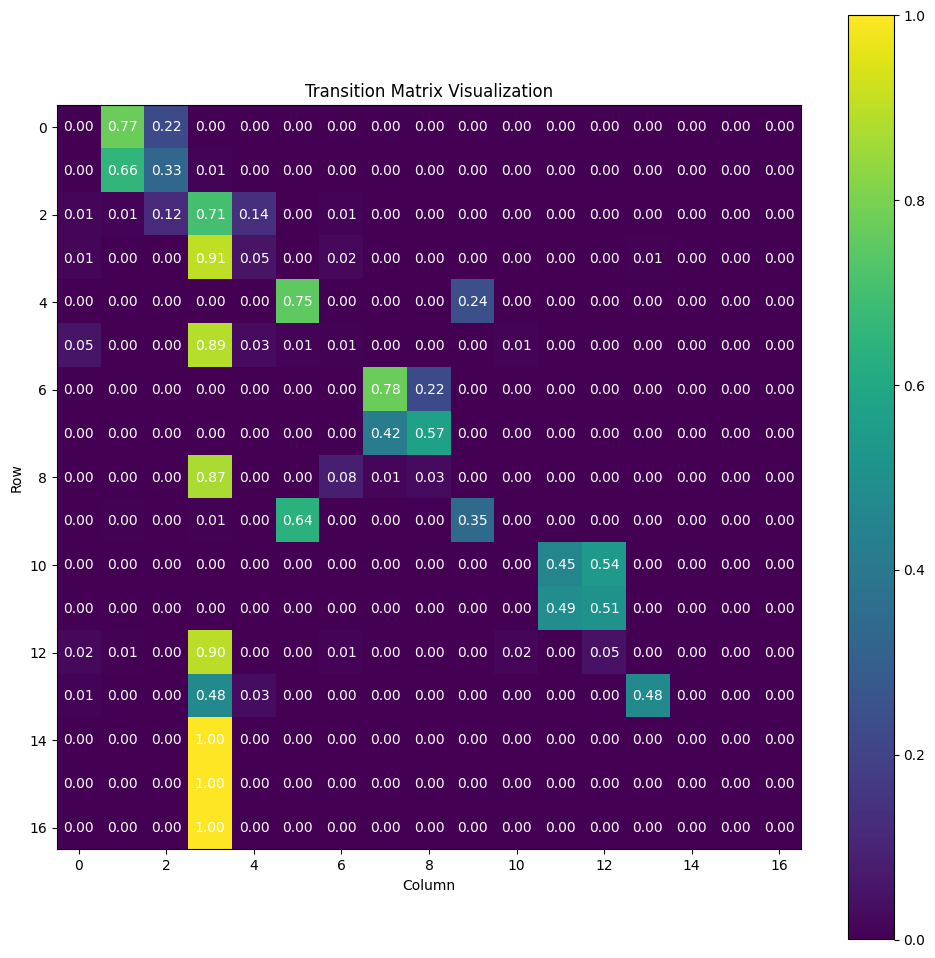

In [84]:
from evaluating import Metrics
hmm_model = HMM(len(tag2id), len(word2id))
hmm_model.train(train_word_lists, train_tag_lists, word2id, tag2id)

In [85]:
# evaluate HMM
pred_tag_lists = hmm_model.test(test_word_lists, word2id, tag2id)
metrics = Metrics(test_tag_lists, pred_tag_lists)
metrics.average_precision()

Progress:
[{'=' * 50}] 100.00%===============================] 100.32%
Average Precision: 0.8648
Average Recall: 0.8724
Average F1-score: 0.8684
Total Support: 14405


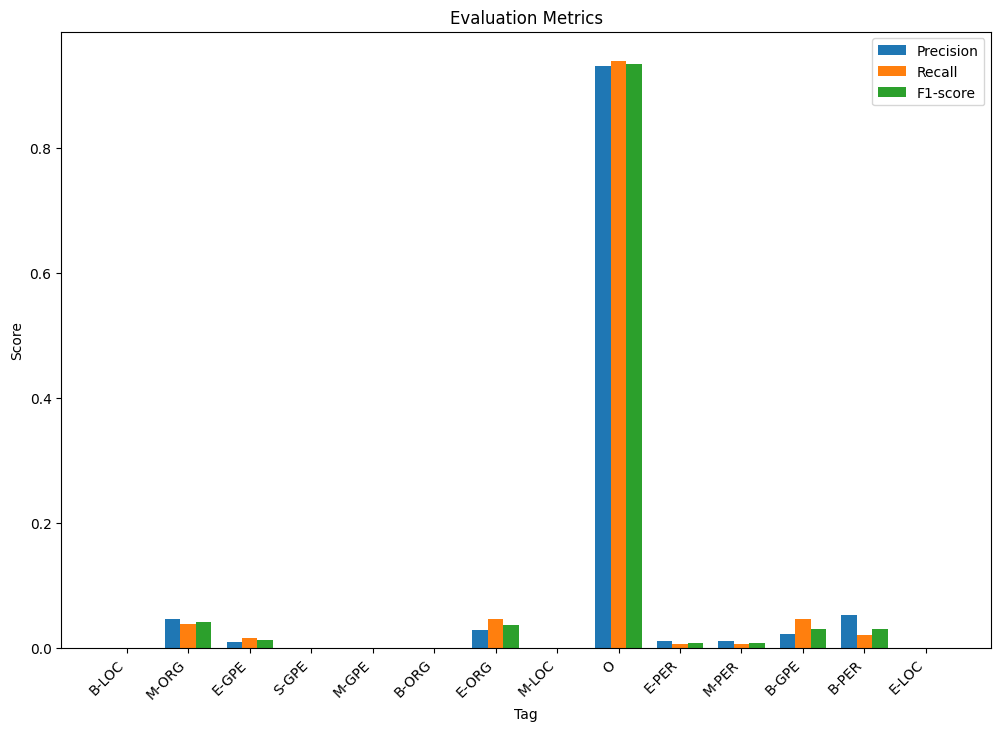

In [86]:
metrics.report_scores("HMM")

In [87]:
metrics.report_confusion_matrix("HMM")


Confusion Matrix:
          B-LOC   M-ORG   E-GPE   S-GPE   M-GPE   B-ORG   E-ORG   M-LOC       O   E-PER   M-PER   B-GPE   B-PER   E-LOC 
  B-LOC       0       0       1       0       0       0       0       0      13       0       0       0       0       0 
  M-ORG       0       6       0       1       0       2       5       0     141       1       0       1       1       0 
  E-GPE       0       0       1       0       0       0       0       0      63       1       0       0       0       1 
  S-GPE       0       0       0       0       0       0       0       0       2       0       0       0       0       0 
  M-GPE       0       0       0       0       0       1       0       0      25       0       0       0       0       0 
  B-ORG       0       3       0       0       0       0       0       0      59       0       0       1       2       0 
  E-ORG       0       5       0       0       0       1       3       0      55       0       1       0       0       0 
  M-LOC      


Confusion Matrix:


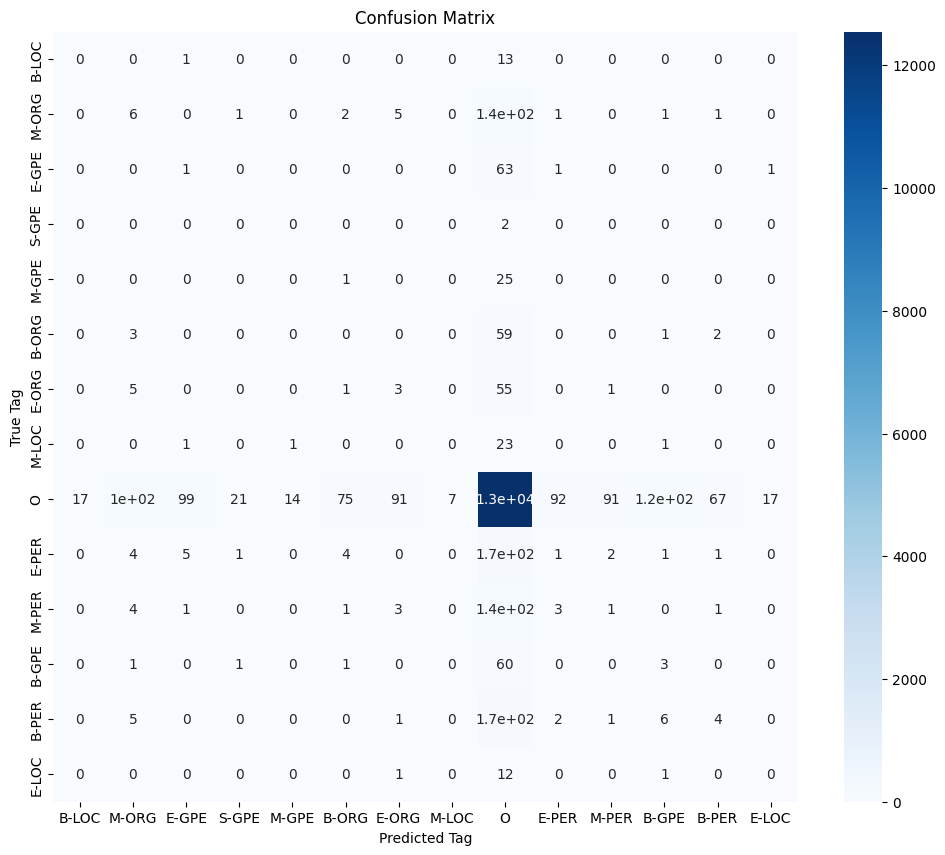

In [88]:
metrics.report_confusion_matrix_visual("HMM")

In [89]:
# evaluate HMM_weighted
pred_tag_lists = hmm_model.test(test_word_lists, word2id, tag2id, weight=1)

metrics = Metrics(test_tag_lists, pred_tag_lists)
metrics.average_precision()

Progress:
[{'=' * 50}] 100.00%===============================] 100.32%
Average Precision: 0.8655
Average Recall: 0.8691
Average F1-score: 0.8671
Total Support: 14405


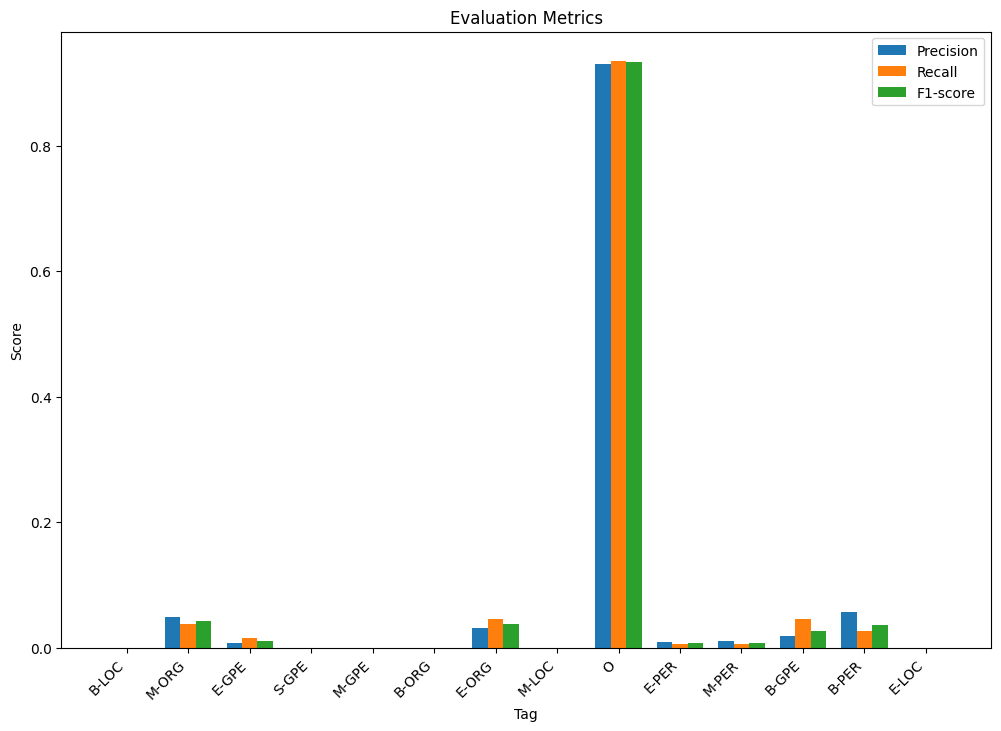

In [90]:
metrics.report_scores("HMM_weighted")

In [91]:
metrics.report_confusion_matrix("HMM_weighted")



Confusion Matrix:
          B-LOC   M-ORG   E-GPE   S-GPE   M-GPE   B-ORG   E-ORG   M-LOC       O   E-PER   M-PER   B-GPE   B-PER   E-LOC 
  B-LOC       0       0       1       0       0       0       0       0      12       0       0       1       0       0 
  M-ORG       0       6       1       1       0       2       5       0     136       2       1       2       2       0 
  E-GPE       0       0       1       0       0       0       0       0      63       1       0       0       0       1 
  S-GPE       0       0       0       0       0       0       0       0       2       0       0       0       0       0 
  M-GPE       0       0       0       0       0       1       0       0      25       0       0       0       0       0 
  B-ORG       0       3       0       0       0       0       0       0      59       0       0       1       2       0 
  E-ORG       0       5       0       0       0       1       3       0      55       0       1       0       0       0 
  M-LOC      


Confusion Matrix:


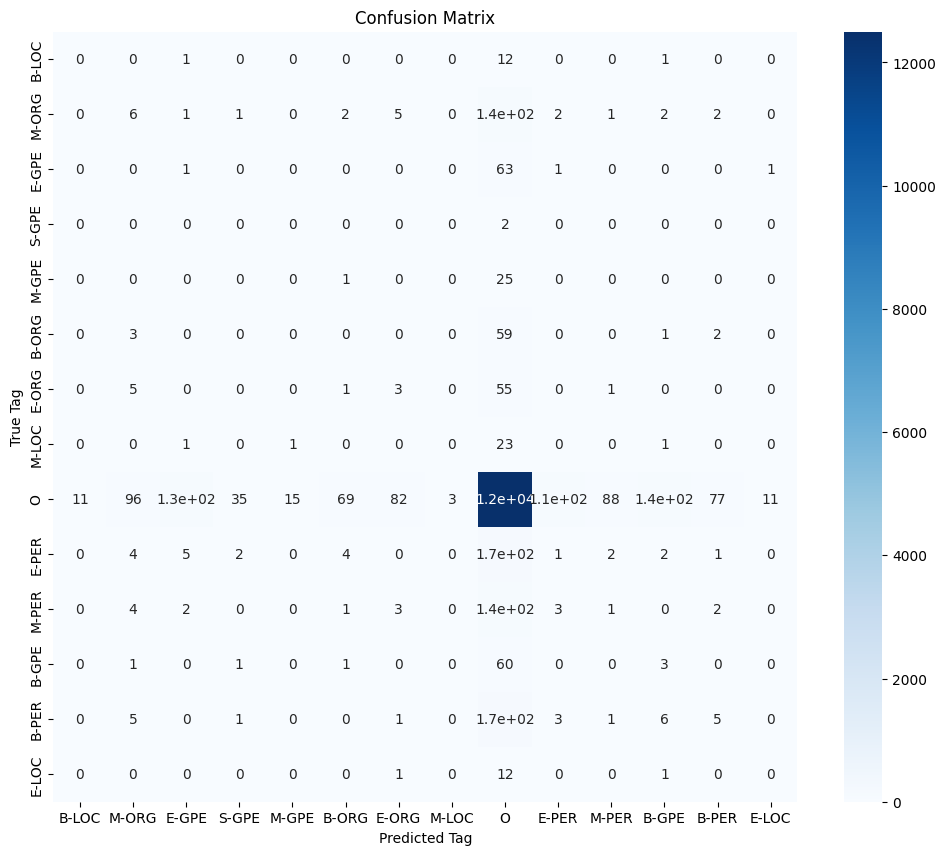

In [92]:
metrics.report_confusion_matrix_visual("HMM_weighted")


## <center> Part3: CRF Named Entity Recognition</center>


In [93]:
from sklearn_crfsuite import CRF

def word2features(sent, i):
    """Extract features for a single word"""
    word = sent[i]
    prev_word = "<s>" if i == 0 else sent[i - 1]
    next_word = "</s>" if i == (len(sent) - 1) else sent[i + 1]
    # Features used:
    # Previous word, current word, next word,
    # Previous word + current word, current word + next word
    features = {
        'w': word,
        'w-1': prev_word,
        'w+1': next_word,
        'w-1:w': prev_word + word,
        'w:w+1': word + next_word,
        'bias': 1
    }
    return features

def sent2features(sent):
    """Extract features for a sequence of words"""
    return [word2features(sent, i) for i in range(len(sent))]


class CRFModel(object):
    def __init__(self,
                 algorithm='lbfgs',  # Limited-memory Broyden–Fletcher–Goldfarb–Shanno
                 c1=0.1,
                 c2=0.1,
                 max_iterations=100,
                 all_possible_transitions=False
                 ):
        self.model = CRF(algorithm=algorithm,
                         c1=c1,
                         c2=c2,
                         max_iterations=max_iterations,
                         all_possible_transitions=all_possible_transitions)

    def train(self, sentences, tag_lists):
        features = [sent2features(s) for s in sentences]
        self.model.fit(features, tag_lists)

    def test(self, sentences):
        features = [sent2features(s) for s in sentences]
        pred_tag_lists = self.model.predict(features)
        return pred_tag_lists


<font color = "red" >However, owing to the coverage of our class CS181, we lack a lot of the knowledge of Conditional Random Fields. We failed to complete the CRF model completely by ourselves, so in the code part we can only use third-party libraries to implement the methods. For some parameters and computation methods in the third-party libraries, we do not have sufficient knowledge to resolve them. Therefore, the purpose of this part is only to compare the accuracy of named entity recognition with the previous HMM part, and it is not part of the workload for this project. We strongly believe in the future when we get enough knowledge accumulation we can solve this problem by ourselves.</font>

In [94]:
from evaluating import Metrics
crf_model = CRFModel()
crf_model.train(train_word_lists, train_tag_lists)
pred_tag_lists = crf_model.test(test_word_lists)
metrics = Metrics(test_tag_lists, pred_tag_lists)
metrics.average_precision()

Average Precision: 0.9127
Average Recall: 0.9313
Average F1-score: 0.9124
Total Support: 14405


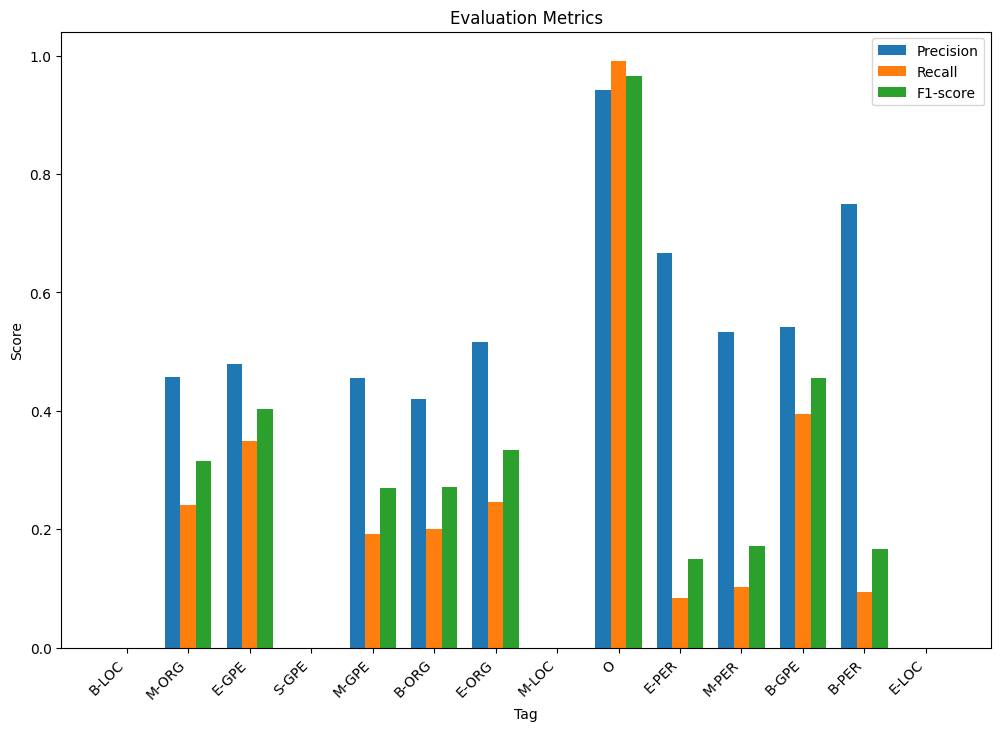

In [95]:
metrics.report_scores("CRF")


In [96]:
metrics.report_confusion_matrix("CRF")


Confusion Matrix:
          B-LOC   M-ORG   E-GPE   S-GPE   M-GPE   B-ORG   E-ORG   M-LOC       O   E-PER   M-PER   B-GPE   B-PER   E-LOC 
  B-LOC       0       0       0       0       0       2       0       0      11       0       0       1       0       0 
  M-ORG       1      38       2       0       0       2       1       1     112       0       0       0       0       1 
  E-GPE       0       0      23       0       0       0       0       0      42       0       1       0       0       0 
  S-GPE       0       0       0       0       0       0       0       0       2       0       0       0       0       0 
  M-GPE       0       0       3       0       5       0       0       0      18       0       0       0       0       0 
  B-ORG       0       2       0       0       0      13       0       0      48       0       0       2       0       0 
  E-ORG       0       0       0       0       0       0      16       0      49       0       0       0       0       0 
  M-LOC      


Confusion Matrix:


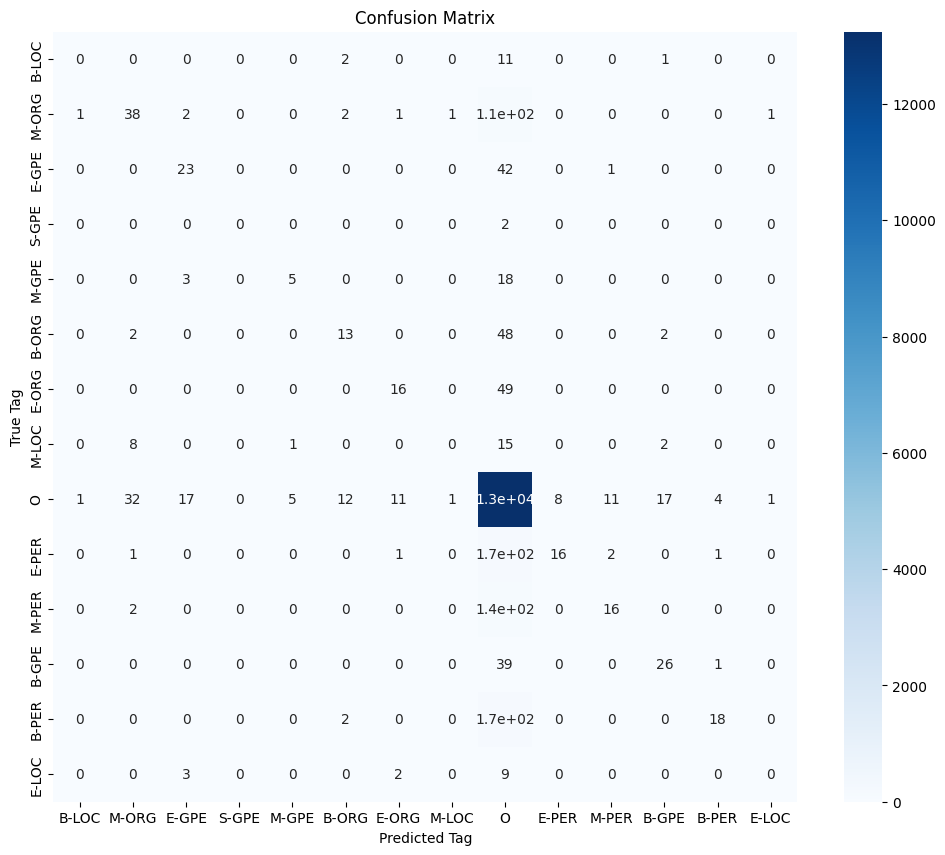

In [97]:
metrics.report_confusion_matrix_visual("CRF")